# Реализация модели сегментации клиентов онлайн магазина с помощью технологий глубокого обучения

E-Commerce Data
https://www.kaggle.com/datasets/carrie1/ecommerce-data
Этот транснациональный набор данных включает в себя все транзакции, произошедшие с 01/12/2010 по 09/12/2011 года в онлайн-розничной компании, зарегистрированной в Великобритании и не имеющей физических магазинов. Компания в основном продает уникальные подарки на любой случай. Многие клиенты компании являются оптовиками.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [ ]:
# Игнорирование ненужных сообщений об ошибках
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [ ]:
# sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

## Обзор датасета

В начале предварительный анализ, чтобы понять структуру и типы столбцов данных

In [ ]:
df = pd.read_csv('data.csv', encoding="ISO-8859-1")

In [ ]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Числовые признаки

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


Категориальные признаки

In [ ]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


Набор данных состоит из 541 909 записей и 8 столбцов.
- InvoiceNo столбец, который содержит номер счета для каждой транзакции
- StockCode столбец, представляющий код продукта для каждого товара
- Description содержит описания продуктов
- Quantity целочисленный столбец, указывающий количество продуктов, приобретенных в каждой транзакции
- InvoiceDate столбец, в котором записываются дата и время каждой транзакции
- UnitPrice столбец, представляющий цену за единицу каждого продукта
- CustomerID столбец, содержащий идентификатор клиента для каждой транзакции
- Country столбец, в котором указывается страна, в которой произошла каждая транзакция

Следующие шаги будут включать более глубокую очистку и предварительную обработку данных для обработки пропущенных значений, потенциально ошибочных данных и создания новых функций, которые могут помочь в достижении целей проекта.

# Очистка данных и преобразование

Этот шаг включает в себя комплексный процесс очистки и преобразования для уточнения набора данных. Он включает в себя устранение пропущенных значений, устранение повторяющихся записей, исправление аномалий в кодах и описаниях продуктов, а также другие необходимые корректировки для подготовки данных для углубленного анализа и моделирования

## Пропущенные значения

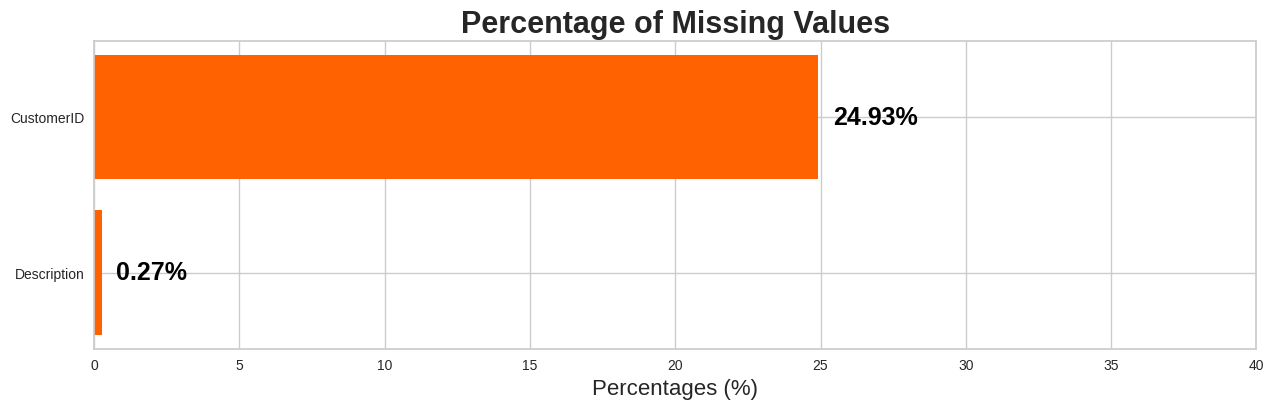

In [ ]:
# Вычисление процента пропущенных значений для каждого столбца
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

missing_percentage.sort_values(ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

ax.set_xlim([0, 40])
plt.title("Процент пропущенных значений", fontweight='bold', fontsize=22)
plt.xlabel('Проценты (%)', fontsize=16)
plt.show()

- CustomerID (24,93% пропущенных значений) Столбец содержит почти четверть недостающих данных. Этот столбец необходим для кластеризации клиентов и создания системы рекомендаций. Использование такого большого процента пропущенных значений может внести в анализ значительную погрешность или шум. Более того, поскольку кластеризация основана на поведении и предпочтениях клиентов, крайне важно иметь точные данные об идентификаторах клиентов. Поэтому удаление строк с отсутствующими идентификаторами CustomerID кажется наиболее разумным подходом для сохранения целостности кластеров и анализа.
- Descripion (0,27 % отсутствующих значений) Столбец содержит небольшой процент пропущенных значений. Однако было замечено, что в данных имеются несоответствия, когда один и тот же StockCode не всегда имеет одинаковое описание. Это указывает на проблемы с качеством данных и потенциальные ошибки в описаниях продуктов. Учитывая эти несоответствия, вменение недостающих описаний на основе StockCode может быть ненадежным. Более того, поскольку процент пропущенных данных довольно низок, было бы разумно удалить строки с отсутствующими описаниями, чтобы избежать распространения ошибок и несоответствий в последующие анализы.

In [ ]:
# Извлечение строк с отсутствующими значениями в столбцах 'CustomerID' или 'Description'
df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [ ]:
# Удаление строк с отсутствующими значениями в столбцах 'CustomerID' и 'Description'
df = df.dropna(subset=['CustomerID', 'Description'])

In [ ]:
# Проверка удаления пропущенных значений
df.isnull().sum().sum()

0

In [ ]:
df.shape

(406829, 8)

## Поиск дубликатов

In [ ]:
# Поиск повторяющихся строк (сохранение всех экземпляров)
duplicate_rows = df[df.duplicated(keep=False)]

# Сортировка данных по определенным столбцам, чтобы увидеть повторяющиеся строки рядом друг с другом
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom


В контексте этого проекта наличие полностью идентичных строк, включая одинаковое время транзакций, предполагает, что это могут быть ошибки записи данных, а не настоящие повторяющиеся транзакции. Сохранение этих повторяющихся строк может привести к появлению шума и потенциальных неточностей в системе кластеризации и рекомендаций. Поэтому лучше удалить эти полностью идентичные повторяющиеся строки из набора данных. Удаление этих строк поможет получить более чистый набор данных, что, в свою очередь, поможет создать более точные кластеры клиентов на основе их уникального покупательского поведения. Более того, это поможет создать более точную систему рекомендаций за счет правильного определения продуктов с наибольшим количеством покупок.

In [ ]:
print(f"Дата содержит {df.duplicated().sum()} дубликатов")
df.drop_duplicates(inplace=True)

The dataset contains 5225 duplicate rows that need to be removed.


In [ ]:
df.shape[0]

401604

## Обработка отмененных транзакций

Чтобы уточнить наше понимание поведения и предпочтений клиентов, нам необходимо принять во внимание отмененные транзакции. Первоначально мы определим эти транзакции, отфильтровав строки, в которых номер начинается с «C». Впоследствии мы проанализируем эти строки, чтобы понять их общие характеристики или закономерности

In [ ]:
# Отфильтруйте строки с InvoiceNo, начинающиеся с "C", и создайте новый столбец, указывающий статус транзакции
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


Все значения в отмененных транзакциях отрицательны, что указывает на то, что это действительно отмененные заказы. Столбец UnitPrice имеет значительный разброс, показывая, что в отмененных транзакциях участвовали различные продукты, от низкой до высокой стоимости.

Учитывая цель проекта — кластеризовать клиентов на основе их покупательского поведения и предпочтений и в конечном итоге создать систему рекомендаций, крайне важно понять модели отказа клиентов. Поэтому стратегия состоит в том, чтобы сохранить эти отмененные транзакции в наборе данных, четко помечая их для облегчения дальнейшего анализа. Этот подход позволит улучшить процесс кластеризации, включив закономерности и тенденции, наблюдаемые в данных об отмене, которые могут отражать определенное поведение или предпочтения клиентов. Разрешить системе рекомендаций предотвращать предложение продуктов, которые с высокой вероятностью будут отменены, тем самым улучшая качество рекомендаций.

In [ ]:
# Определение процента отмененных транзакций
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100
print(f"Процент отмененных транзакций {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.21%


## Исправление аномалий StockCode

Прежде всего, найдем количество уникальных кодов акций и построим график 10 самых частых кодов акций вместе с их процентной частотой

In [ ]:
# Поиск количества уникальных биржевых кодов
unique_stock_codes = df['StockCode'].nunique()
print(f"Число уникальных типов в датасете {unique_stock_codes}")

The number of unique stock codes in the dataset is: 3684


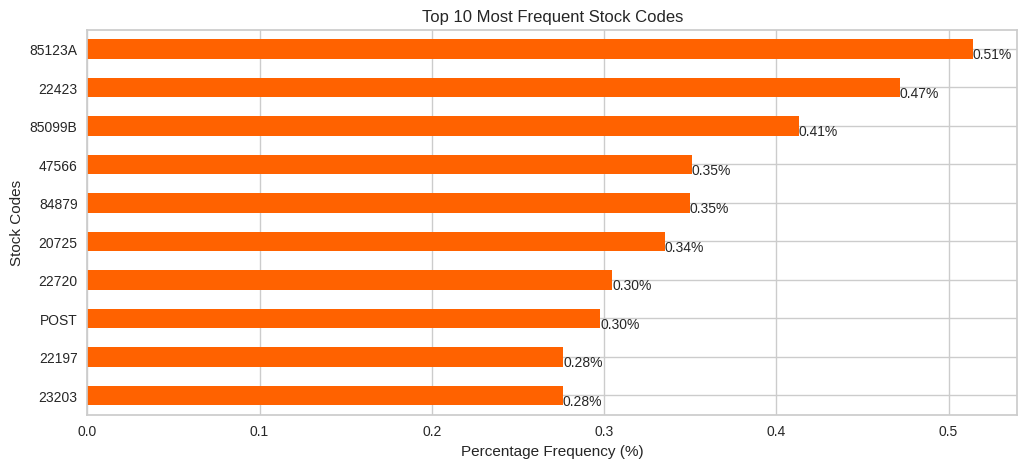

In [ ]:
# 10 наиболее часто встречающихся биржевых кодов
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#ff6200')

for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('10 наиболее часто встречающихся биржевых кодов')
plt.xlabel('Процент повторений (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

- набор данных содержит 3684 уникальных кодов акций, что указывает на значительное разнообразие продуктов, доступных в розничном интернет-магазине. Это разнообразие потенциально может привести к выявлению отдельных групп клиентов с предпочтениями к разным типам продуктов. Популярные товары. Более пристальный взгляд на 10 наиболее частых кодов акций может дать представление о популярных продуктах или категориях, которые часто покупают покупатели.
- большинство биржевых кодов состоят из 5 или 6 символов, существуют некоторые аномалии, такие как код «POST». Эти аномалии могут представлять собой услуги или транзакции, не связанные с продуктами (например, почтовые расходы), а не фактические продукты.

Чтобы сохранить фокус проекта, который заключается в кластеризации на основе покупок продуктов и создании системы рекомендаций, эти аномалии следует дополнительно исследовать и, возможно, лечить соответствующим образом, чтобы обеспечить целостность данных.

Чтобы углубиться в выявление этих аномалий, изучим частоту количества числовых символов в биржевых кодах, что может дать представление о природе этих необычных записей

In [ ]:
# Поиск количества цифровых символов в каждом уникальном биржевом коде
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

print("Количество цифровых символов в каждом уникальном биржевом коде")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
dtype: int64


Большинство уникальных кодов акций содержат ровно 5 цифровых символов, что, по-видимому, является стандартным форматом для представления кодов продуктов в этом наборе данных.

7 кодов акций не содержат цифровых символов, а 1 код акций содержит только 1 цифровой символ. Они явно отклоняются от стандартного формата и требуют дальнейшего изучения, чтобы понять их природу и то, представляют ли они действительные транзакции с продуктами. Теперь давайте определим биржевые коды, содержащие 0 или 1 числовой символ, чтобы лучше понять эти аномалии

In [ ]:
# Печать биржевых кодов с цифровыми символами 0 и 1
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


Посчитаем процент записей с этими аномальными кодами акций

In [ ]:
# Вычисление процента записей с этими биржевыми кодами
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100
print(f"Процент записей с аномальными кодами запасов {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.48%


Эти коды, похоже, представляют собой транзакции, не связанные с продуктами, такие как BANK CHARGES, POST. Поскольку они не представляют собой фактические продукты и составляют очень небольшую часть набора данных, включение их в анализ может привести к зашумить и исказить систему кластеризации и рекомендаций.

In [ ]:
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [ ]:
df.shape[0]

399689

## Очистка столбца с описаниями

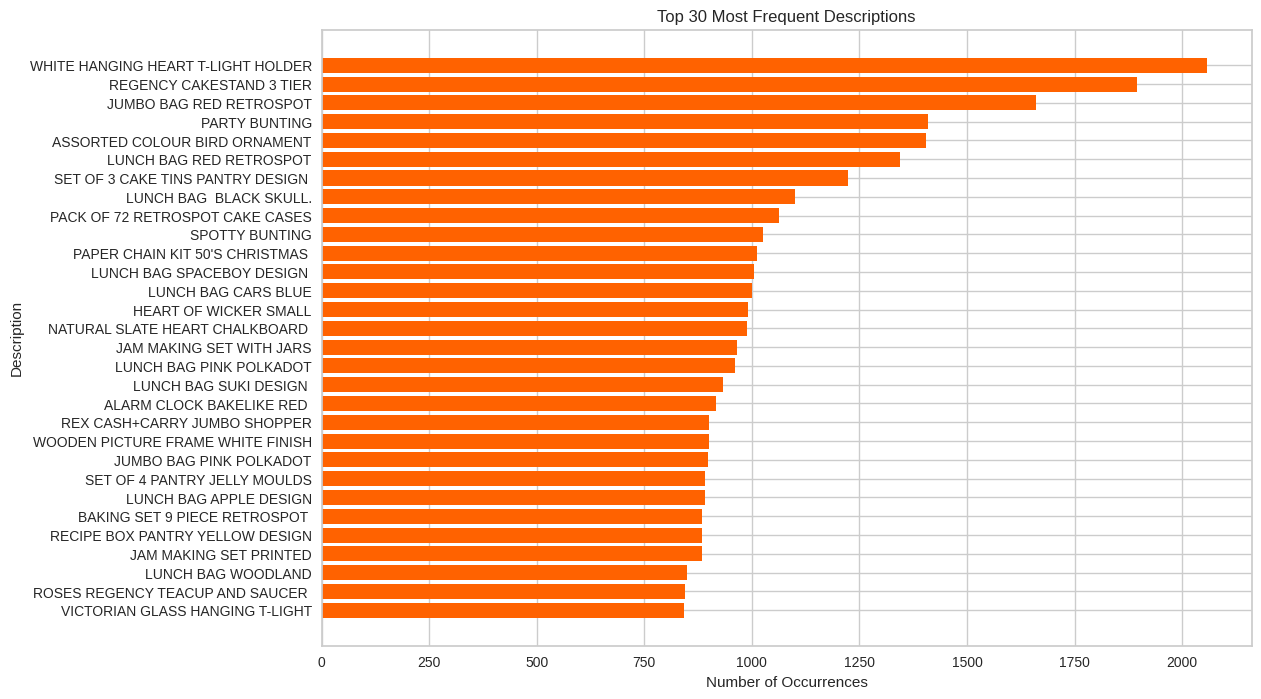

In [ ]:
# Вычисление встречаемости каждого уникального описания
description_counts = df['Description'].value_counts()

top_30_descriptions = description_counts[:30]

plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')
plt.xlabel('Количество вхождений')
plt.ylabel('Описание')
plt.title('Топ-30 самых частых описаний')
plt.show()

Наиболее частыми описаниями обычно являются предметы домашнего обихода, особенно кухонные принадлежности, пакеты для обеда и декоративные предметы.

Интересно, что все описания написаны заглавными буквами, что может быть стандартным форматом для ввода описаний продуктов в базу данных. Однако, стоит проверить, есть ли описания, введенные в нижнем регистре или в сочетании стилей регистра.

In [ ]:
# уникальные описания, содержащие символы нижнего регистра
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

print("уникальные описания, содержащие символы нижнего регистра")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


При просмотре описаний, содержащих строчные буквы, становится очевидно, что некоторые записи не являются описаниями продуктов, например «Перевозка на следующий день» и «Изображение с высоким разрешением». Кажется, что эти записи не связаны с реальными продуктами и могут представлять другие типы информации или детали услуг.

- Удалим строки, в описаниях которых содержится информация, связанная с услугами, например «Перевозка на следующий день» и «Изображение в высоком разрешении», поскольку они не представляют собой реальные продукты и не будут способствовать созданию системы кластеризации и рекомендаций, которую мы стремимся создать.
- Для остальных описаний со смешанным регистром стандартизируем текст в верхний регистр, чтобы обеспечить единообразие во всем наборе данных. Это также поможет снизить вероятность дублирования записей с разными стилями регистра.

In [ ]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# процент записей с описаниями, относящимися к сервису
service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

print(f"процент записей с описаниями, относящимися к сервису {service_related_percentage:.2f}%")


df = df[~df['Description'].isin(service_related_descriptions)]
# all descr to upper case
df['Description'] = df['Description'].str.upper()

The percentage of records with service-related descriptions in the dataset is: 0.02%


In [ ]:
df.shape[0]

399606

Теперь взглянем на статистическое описание столбца UnitPrice

In [ ]:
df['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

Минимальное значение цены единицы продукции равно нулю. Это говорит о том, что в некоторых транзакциях цена за единицу равна нулю, что потенциально указывает на бесплатный товар или ошибку при вводе данных. Чтобы понять их природу, важно глубже изучить эти транзакции с нулевой ценой за единицу.

In [ ]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


Сделок с нулевой ценой за единицу относительно немного (33 сделки). Эти транзакции имеют большую вариативность количества участвующих товаров в диапазоне от 1 до 12540 со значительным стандартным отклонением.

In [ ]:
# Удаление записей с нулевой ценой за единицу, чтобы избежать потенциальных ошибок при вводе данных
df = df[df['UnitPrice'] > 0]

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df.shape[0]

399573

# Feature Engineering

## RFM Features

RFM — это метод, используемый для анализа ценности клиента и сегментации клиентской базы.
- Недавность (R) этот показатель показывает, как недавно клиент совершил покупку. Более низкое значение давности означает, что клиент совершил покупку совсем недавно, что указывает на более высокий уровень взаимодействия с брендом.
- Частота (F) этот показатель показывает, как часто клиент совершает покупку в течение определенного периода. Более высокое значение частоты указывает на клиента, который чаще взаимодействует с бизнесом, что предполагает более высокую лояльность или удовлетворенность.
- Денежный (M) этот показатель представляет собой общую сумму денег, потраченную клиентом за определенный период. Клиенты, имеющие более высокую денежную стоимость, внесли больший вклад в бизнес, что указывает на их потенциальную высокую пожизненную ценность.

Вместе эти показатели помогают понять покупательское поведение и предпочтения клиентов, что имеет решающее значение для персонализации маркетинговых стратегий и создания системы рекомендаций.

## Recency (R)

На этом этапе мы фокусируемся на понимании того, как недавно клиент совершил покупку. Это важнейший аспект сегментации клиентов, поскольку он помогает определить уровень вовлеченности клиентов.
- Количество дней с момента последней покупки. Более низкое значение указывает на то, что клиент совершил покупку недавно, что подразумевает более высокий уровень вовлеченности в бизнес, тогда как более высокое значение может указывать на прекращение или снижение вовлеченности. Понимая давность покупок, компании могут адаптировать свои маркетинговые стратегии для повторного привлечения клиентов, которые давно не совершали покупок, потенциально увеличивая удержание клиентов и повышая их лояльность.

In [ ]:
# Преобразование даты выставления счета в тип даты и времени
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# выделяем только дату
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# самая раняя покупка для каждого клиента
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# самая последняя дата во всем наборе данных
most_recent_date = df['InvoiceDay'].max()

# Преобразование лня выставления счета в тип даты и времени перед вычитанием
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# число дней с момента последней покупки для каждого покупателя
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# удаляем лишнее
customer_data.drop(columns=['InvoiceDay'], inplace=True)

Теперь фрейм данных customer_data содержит столбец Days_Since_Last_Purchas

In [ ]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


customer_data, в конечном итоге будет содержать все клиентоориентированные фичи, которые мы планируем создать.

## Frequency (F)

Создадим 2 фичи, которые количественно оценят частоту взаимодействия покупателя с продавцом
- Всего транзакций. Это помогает понять уровень взаимодействия покупателя с продавцом.
- Всего куплено продуктов. Это дает представление о покупательском поведении клиентов с точки зрения объема приобретенных продуктов.

In [ ]:
# количество операций для каждого клиента
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# количество купленных товаров для каждого покупателя
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# слияние
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


## Monetary (M)

Создадим еще 2 фичи, которые представляют денежный аспект транзакций клиента
- Общие расходы. Она рассчитывается как сумма произведения UnitPrice и Quantity для всех транзакций, совершенных клиентом. Показывает общий доход, полученный каждым клиентом, что является прямым показателем ценности клиента для бизнеса.
- Средняя стоимость транзакции. Эта фича рассчитывается как общие расходы, разделенные на общее количество транзакций для каждого клиента. Он указывает среднюю стоимость транзакции, осуществленной клиентом. Этот показатель полезен для понимания покупательского поведения клиентов в расчете на транзакцию, что может помочь в адаптации маркетинговых стратегий и предложений для различных сегментов клиентов на основе их средней структуры расходов

In [ ]:
# рассчет общих трат для каждого пользователя
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# среднее значение одной транзакции
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# добавление фичей
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


## Product Diversity

Посмотрим на разнообразие покупательского поведения клиентов. Понимание разнообразия продуктов может помочь в разработке персонализированных маркетинговых стратегий и рекомендаций по продуктам.
- Купленные уникальные продукты. Более высокое значение указывает на то, что у покупателя разнообразные вкусы или предпочтения, и он покупает широкий ассортимент товаров, тогда как более низкое значение может указывать на целенаправленное или конкретное предпочтение. Понимание разнообразия покупок продуктов может помочь сегментировать клиентов на основе разнообразия их покупок, что может стать решающим фактором при персонализации рекомендаций по продуктам.

In [ ]:
# количество уникальных товаров в покупках
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# слияние
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


## Behavioral Features

Поведенческие фичи дадут нам представление о предпочтениях клиентов относительно того, когда им нравится делать покупки, что может иметь решающее значение для персонализации их покупательского опыта.

- Среднее количество дней между покупками. Понимание этого может помочь спрогнозировать, когда клиент, скорее всего, совершит следующую покупку, что может стать решающим показателем для целевого маркетинга и персонализированных рекламных акций.
- День любимых покупок. Эта информация может помочь определить предпочтительные дни покупок для различных сегментов клиентов, что можно использовать для оптимизации маркетинговых стратегий и рекламных акций для разных дней недели.
- Любимый час покупок. Определение любимого часа для покупок может помочь оптимизировать время проведения маркетинговых кампаний и рекламных акций, чтобы они соответствовали времени, когда различные сегменты клиентов наиболее активны.

In [ ]:
# день недели
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# среднее количество дней между последовательными покупками
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# любимый день покупок на неделе
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# любимый час для покупок
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


## Geographic Features

Добавим фичу, отражающую географическое расположение клиентов.
- Страна. Включение данных по стране может помочь нам понять модели и предпочтения покупок в конкретных регионах. В разных регионах могут быть разные предпочтения и покупательское поведение, что может иметь решающее значение для персонализации маркетинговых стратегий и планирования запасов. Кроме того, это может сыграть важную роль в оптимизации логистики и цепочки поставок, особенно для интернет-магазина, где доставка и доставка играют важную роль.

In [ ]:
df['Country'].value_counts(normalize=True).head()

United Kingdom    0.890971
Germany           0.022722
France            0.020402
EIRE              0.018440
Spain             0.006162
Name: Country, dtype: float64

Учитывая, что значительная часть (89%) транзакций происходит из Великобритании, мы могли бы рассмотреть возможность создания двоичной функции, указывающей, происходит ли транзакция из Великобритании или нет. Этот подход потенциально может упростить процесс кластеризации без потери важной географической информации, особенно при рассмотрении применения таких алгоритмов, как K-средние, которые чувствительны к размерности пространства признаков.

In [ ]:
# группировка по клиентам и странам. получение количества транзакций для каждого покупателя
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# страна с наибольшим числом транзакций для каждого клиента
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# флаг, из ВБ или нет
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [ ]:
customer_data['Is_UK'].value_counts()

1    3866
0     416
Name: Is_UK, dtype: int64

## Cancellation Insights

- Частота отмены. Понимание частоты отмены может помочь нам выявить клиентов, которые с большей вероятностью отменяют транзакции. Это может быть индикатором неудовлетворенности или других проблем, и понимание этого может помочь нам разработать стратегии, позволяющие сократить количество отмен и повысить удовлетворенность клиентов.
- Коэффициент отмены. Эта метрика дает нормализованное представление о поведении отмены. Высокий процент отказов может указывать на неудовлетворенный сегмент клиентов. Определив эти сегменты, мы можем разработать целевые стратегии, позволяющие улучшить качество их покупок и потенциально снизить процент отказов от покупок.

In [ ]:
# общее количество операций для каждого клиента
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# число отмененных транзакций для каждого клиента
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

customer_data['Cancellation_Frequency'].fillna(0, inplace=True)
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


## Seasonality & Trends

- Monthly_Spending_Mean Это помогает нам оценить общую покупательскую привычку каждого клиента. Более высокое среднее значение указывает на клиента, который тратит больше и потенциально проявляет интерес к продуктам премиум-класса, тогда как более низкое среднее значение может указывать на клиента, более экономного в плане бюджета.
- Monthly_Spending_Std. Более высокое значение сигнализирует о том, что расходы клиентов значительно колеблются от месяца к месяцу, что, возможно, указывает на спорадические крупные покупки. Напротив, более низкое значение предполагает более стабильные и последовательные привычки расходования средств. Понимание этой изменчивости может помочь в разработке персонализированных рекламных акций или скидок в периоды, когда ожидается, что люди будут тратить больше.
- Spending_Trend. Положительное значение указывает на тенденцию к увеличению расходов, возможно, указывая на растущую лояльность или удовлетворенность. И наоборот, отрицательная тенденция может сигнализировать о снижении интереса или удовлетворенности, подчеркивая необходимость стратегий повторного вовлечения. Значение, близкое к нулю, означает стабильные привычки расходования средств. Признание этих тенденций может помочь в разработке стратегий по сохранению или изменению структуры расходов клиентов, повышая эффективность маркетинговых кампаний.

In [ ]:
# извлекаем месяц
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# растраты для каждого пользователя по месяцам
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# сезонность покупок
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

def calculate_trend(spend_data):
    # Если имеется более одной точки данных, мы вычисляем тренд с помощью линейной регрессии
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # Если есть только одна точка данных, тренд вычислить невозможно, следовательно, мы возвращаем 0
    else:
        return 0

# Примените функцию calculate_trend, чтобы найти тенденцию расходов для каждого клиента
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


In [ ]:
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)
customer_data = customer_data.convert_dtypes()

In [ ]:
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0
5,12352,36,8,463,1265.41,158.17625,57,3.13253,1,14,0,1,0.125,316.3525,134.700629,9.351
6,12353,204,1,20,89.0,89.0,4,0.0,3,17,0,0,0.0,89.0,0.0,0.0
7,12354,232,1,530,1079.4,1079.4,58,0.0,3,13,0,0,0.0,1079.4,0.0,0.0
8,12355,214,1,240,459.4,459.4,13,0.0,0,13,0,0,0.0,459.4,0.0,0.0
9,12356,22,3,1573,2487.43,829.143333,52,5.315789,1,9,0,0,0.0,829.143333,991.462585,-944.635


In [ ]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   Int64  
 1   Days_Since_Last_Purchase        4282 non-null   Int64  
 2   Total_Transactions              4282 non-null   Int64  
 3   Total_Products_Purchased        4282 non-null   Int64  
 4   Total_Spend                     4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_Products_Purchased       4282 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Day_Of_Week                     4282 non-null   Int64  
 9   Hour                            4282 non-null   Int64  
 10  Is_UK                           4282 non-null   Int64  
 11  Cancellation_Frequency          4282 non-null   Int64  
 12  Cancellation_Rate               42

- CustomerID Идентификатор, уникально присваиваемый каждому клиенту и используемый для различения отдельных клиентов.
- Days_Since_Last_Purchase Число дней, прошедших с момента последней покупки клиента.
- Total_Transactions Общее количество транзакций, совершенных клиентом.
- Total_Products_Purchased Общее количество продуктов, приобретенных клиентом по всем транзакциям.
- Total_Spend Общая сумма денег, потраченная клиентом по всем транзакциям.
- Average_Transaction_Value Средняя стоимость транзакций клиента, рассчитываемая как общие расходы, разделенные на количество транзакций.
- Unique_Products_Purchased Количество различных продуктов, приобретенных клиентом.
- Average_Days_Between_Purchases Среднее количество дней между последовательными покупками, совершенными клиентом.
- Day_Of_Week День недели, когда покупатель предпочитает делать покупки, представленный в числовом виде (0 — понедельник, 6 — воскресенье).
- Hour Час дня, когда покупатель предпочитает совершать покупки, представленный в 24-часовом формате.
- Is_UK Бинарная переменная, указывающая, находится ли клиент в Великобритании (1) или нет (0).
- Cancellation_Frequency Общее количество транзакций, которые клиент отменил.
- Cancellation_Rate Доля транзакций, которые клиент отменил, рассчитывается как частота отмены, деленная на общее количество транзакций.
- Monthly_Spending_Mean Среднемесячные расходы клиента.
- Monthly_Spending_Std Стандартное отклонение ежемесячных расходов клиента, указывающее на изменчивость структуры их расходов.
- Spending_Trend Числовое представление тенденции расходов клиента с течением времени. Положительное значение указывает на тенденцию к увеличению, отрицательное значение указывает на тенденцию к снижению, а значение, близкое к нулю, указывает на стабильную тенденцию.

# Обнаружение и обработка выбросов

При кластеризации K-средних алгоритм чувствителен как к масштабу данных, так и к наличию выбросов, поскольку они могут существенно влиять на положение центроидов, что потенциально может привести к неправильному назначению кластеров. Однако, учитывая контекст этого проекта, где конечной целью является понимание поведения и предпочтений клиентов с помощью кластеризации K-средних, было бы более разумно решить проблему выбросов после этапа разработки функций, на котором мы создаем набор данных, ориентированный на клиента.